In [ ]:
!pip install pandas numpy scikit-learn tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import SparseCategoricalCrossentropy

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/eng-french.csv')
df.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [ ]:
df.shape

(175621, 2)

In [ ]:
# Separating the English and French datasets
eng = df['English words/sentences']
fra = df['French words/sentences']

In [ ]:
eng_word_counter = Counter([word for sentence in eng for word in sentence.split()])
print("Total count of English words:",len([word for sentence in eng for word in sentence.split()]))
print("Count of distinct English words:",len(eng_word_counter))
print("10 most common English words:",list(zip(*eng_word_counter.most_common(10)))[0])

Total count of English words: 1082098
Count of distinct English words: 27393
10 most common English words: ('I', 'to', 'you', 'the', 'a', 'is', 'Tom', 'of', 'in', 'have')


In [ ]:
fra_word_counter = Counter([word for sentence in fra for word in sentence.split()])
print("Total count of French words:",len([word for sentence in fra for word in sentence.split()]))
print("Count of distinct French words:",len(fra_word_counter))
print("10 most common French words:",list(zip(*fra_word_counter.most_common(10)))[0])

Total count of French words: 1177832
Count of distinct French words: 44918
10 most common French words: ('de', 'Je', '?', 'pas', 'que', 'à', 'ne', 'la', 'le', 'Il')


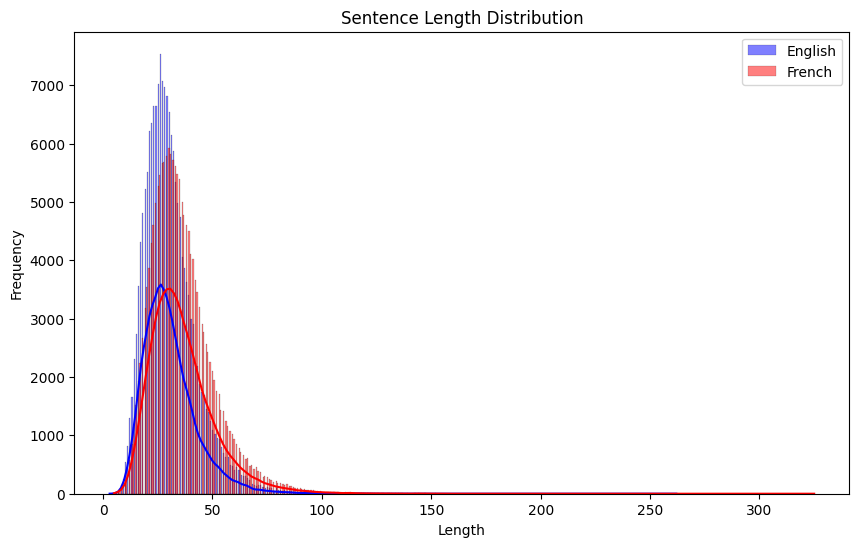

In [ ]:
# Calculate sentence lengths
df['English_length'] = df['English words/sentences'].apply(len)
df['French_length'] = df['French words/sentences'].apply(len)

# Plot sentence lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['English_length'], color='blue', label='English', kde=True)
sns.histplot(df['French_length'], color='red', label='French', kde=True)
plt.title('Sentence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


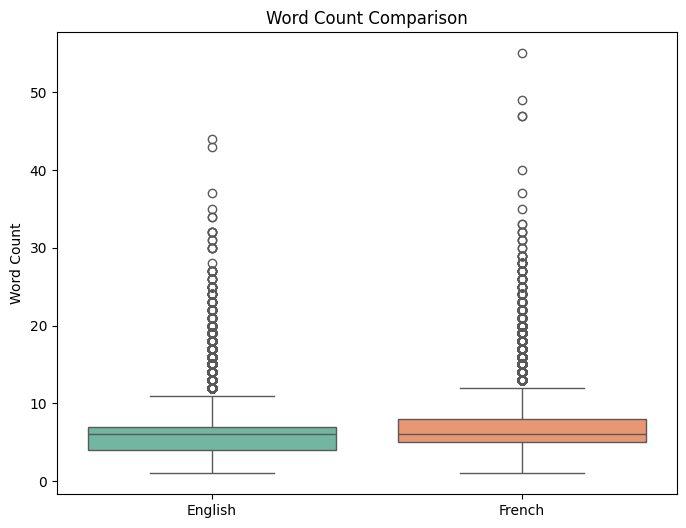

In [ ]:
# Calculate word counts
df['English_word_count'] = df['English words/sentences'].apply(lambda x: len(x.split()))
df['French_word_count'] = df['French words/sentences'].apply(lambda x: len(x.split()))

# Boxplot comparison
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[['English_word_count', 'French_word_count']], palette='Set2')
plt.title('Word Count Comparison')
plt.xticks([0, 1], ['English', 'French'])
plt.ylabel('Word Count')
plt.show()


In [ ]:

# Create tokenizers
def create_tokenizer(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

# Prepare English tokenizer
eng_tokenizer = create_tokenizer(eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
max_eng_sent_len = 22

# Prepare French tokenizer
fra_tokenizer = create_tokenizer(fra)
fra_vocab_size = len(fra_tokenizer.word_index) + 1
max_fra_sent_len = 22

def encode_sequences(tokenizer, sentences, max_sent_len):
    text_to_seq = tokenizer.texts_to_sequences(sentences)
    text_pad_seq = pad_sequences(text_to_seq, maxlen=max_sent_len, padding='post')
    return text_pad_seq

X = encode_sequences(eng_tokenizer, eng, max_eng_sent_len)
y = encode_sequences(fra_tokenizer, fra, max_fra_sent_len)


In [ ]:
print("English vocabulary size:", eng_vocab_size)
print("Maximum length of English sentences:", max_eng_sent_len)

English vocabulary size: 14532
Maximum length of English sentences: 22


In [ ]:
print("French vocabulary size:", fra_vocab_size)
print("Maximum length of French sentences:", max_fra_sent_len)

French vocabulary size: 30661
Maximum length of French sentences: 22


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,shuffle=True,random_state=101)

In [ ]:
def create_model(src_vocab_size, dest_vocab_size, src_timesteps, dest_timesteps, no_units):
    """
    Args:
    - src_vocab_size: Vocabulary size of  english.
    - dest_vocab_size: Vocabulary size of french.
    - src_timesteps: Length of input sequences.
    - dest_timesteps: Length of output sequences.
    - no_units: Number of units in LSTM layers.
    """

    model = Sequential()

    # Embedding layer: Converts input tokens to dense vectors and handles padding with mask_zero=True.
    model.add(Embedding(src_vocab_size, no_units, input_length=src_timesteps, mask_zero=True))

    # Encoder LSTM: Encodes the input sequence into a context vector.
    model.add(LSTM(no_units))

    # RepeatVector: Duplicates the context vector for the target sequence length.
    model.add(RepeatVector(dest_timesteps))

    # Decoder LSTM: Decodes the repeated context vector into a sequence.
    model.add(LSTM(no_units, return_sequences=True))

    # Fully connected layers applied at each time step for predictions.
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.2))  # Dropout to prevent overfitting.
    model.add(TimeDistributed(Dense(dest_vocab_size, activation='softmax')))

    return model


In [ ]:
model = create_model(eng_vocab_size,fra_vocab_size,max_eng_sent_len,max_fra_sent_len,512)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss=SparseCategoricalCrossentropy(),optimizer='rmsprop',metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy',patience=3,mode='max',verbose=1)
lr = ReduceLROnPlateau(monitor='val_accuracy',patience=2,mode='max',verbose=1,factor=0.1,min_lr=0.001)

Epoch 1/7
292/292 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.7082 - loss: 2.2265 - val_accuracy: 0.7128 - val_loss: 2.0925 - learning_rate: 0.0010
Epoch 2/7
292/292 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.7124 - loss: 2.0926 - val_accuracy: 0.7159 - val_loss: 2.0562 - learning_rate: 0.0010
Epoch 3/7
292/292 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.7179 - loss: 2.0222 - val_accuracy: 0.7189 - val_loss: 1.9886 - learning_rate: 0.0010
Epoch 4/7
292/292 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.7202 - loss: 1.9730 - val_accuracy: 0.7194 - val_loss: 1.9761 - learning_rate: 0.0010
Epoch 5/7
292/292 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.7212 - loss: 1.9476 - val_accuracy: 0.7238 - val_loss: 1.9115 - learning_rate: 0.0010
Epoch 6/7
292/292 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.7250 - loss: 1.8991 - val_accuracy: 0.7275 - val_loss: 1.8750 - learning_rate: 0.0010
Epoch 7/7
292/292 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.7305 - loss: 1.8516 - 

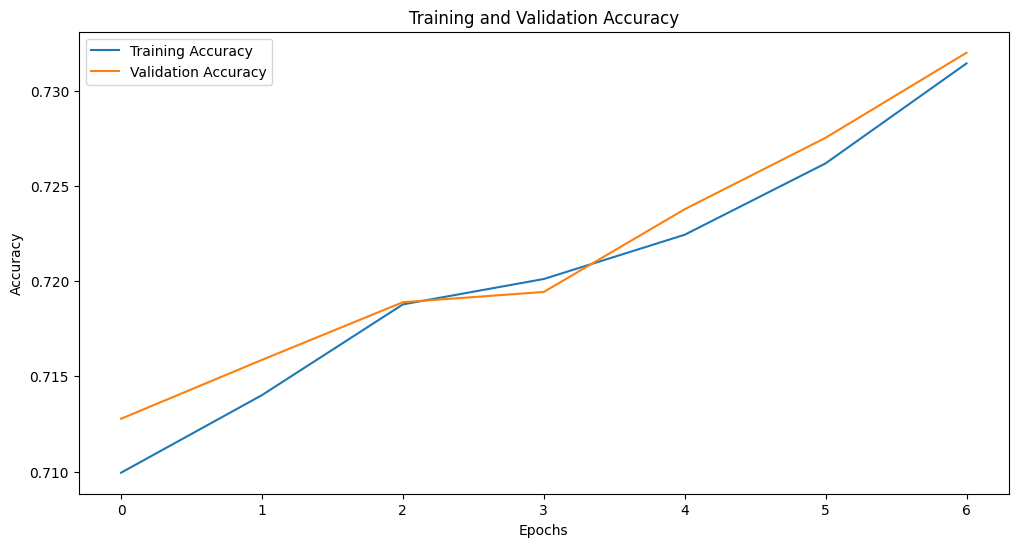

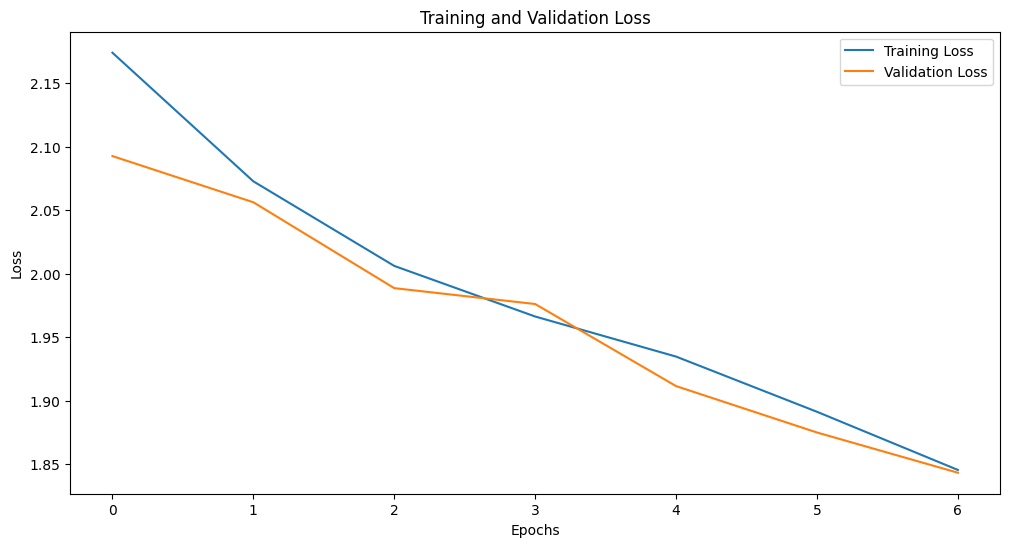

In [ ]:
import matplotlib.pyplot as plt

# Save the training history
history = model.fit(
    X_train,
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1),
    epochs=7,
    batch_size=512,
    callbacks=[es, lr],
    validation_data=(X_test, y_test.reshape(y_test.shape[0], y_test.shape[1], 1))
)

# Plot the accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.evaluate(X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1))

824/824 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - accuracy: 0.7314 - loss: 1.8450


[1.8432947397232056, 0.7319930791854858]

In [ ]:
model.save('english_to_french_translator.keras')

In [ ]:
translator_model = load_model('/content/drive/MyDrive/english_to_french_translator.keras')
translator_model

<Sequential name=sequential, built=True>